# **Задание Pro**

Напишите **PSPNet** для сегментации на базе самолетов, добейтесь максимально возможной точности.

# Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import concatenate, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from google.colab import files
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация самолетов


### Задание глобальных параметров

In [ ]:
img_width  = 176     # Ширина
img_height = 320    # Высота
directory_air     = '/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Airplane/'  # Путь с оригинальными изображениями
directory_segment = '/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Segment/'  # Путь с сегментрированными изображениями
num_classes = 2     # Количество классов

## Загрузка изображений



### Оригинальные изображения

In [ ]:
# Создаем пустой список для хранений оригинльных изображений
images_airplane = []

cur_time = time.time()
for filename in sorted(os.listdir(directory_air)):
  images_airplane.append(image.load_img(os.path.join(directory_air,filename), target_size=(img_width, img_height)))

print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - cur_time, 2)} cекунд')

**Просмотр измененных изображений самолетов**

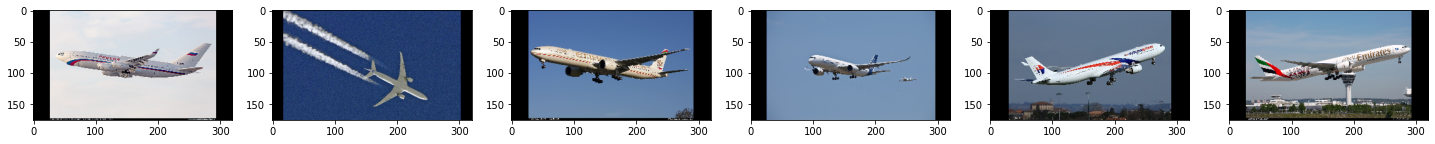

In [ ]:
n = 6
fig, ax = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(images_airplane)
  ax[i].imshow(img)
plt.show()

### Сегментированные изображения

In [ ]:
segments_airplane = []
cur_time = time.time()
for filename in sorted(os.listdir(directory_segment)):
  segments_airplane.append(image.load_img(os.path.join(directory_segment, filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - cur_time, 2)} cекунд')

Обучающая выборка завершина. Время загрузки: 36.26 cекунд


**Просмотр измененных сегментированных изображений**

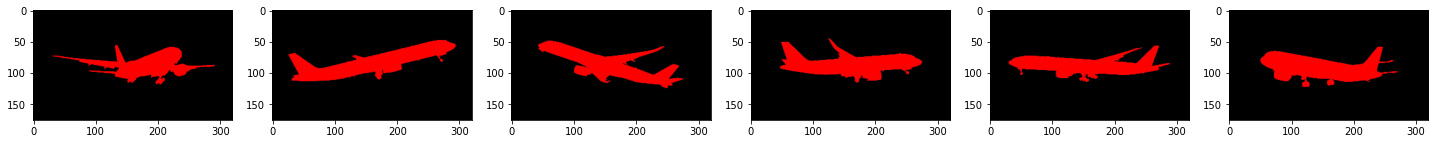

In [ ]:
n = 6
fig, ax = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(segments_airplane)
  ax[i].imshow(img)
plt.show()

## Создание выборки



In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
  index = 0
  if (color[0] + color[1] + color[2] > 20):
    index = 1
  return index

In [ ]:
# Обратная функция из индекса в пиксель
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0]     # Черный
  elif index == 1:
    color = [255, 0 , 0]  # Красный
  return color

In [ ]:
# Функция перевода индекса пикслея в OHE
def rgbToOhe(y, num_classes):
  y_shape = y.shape                          # Запоминаем форму массива для решейпа
  y = y.reshape(y.shape[0] * y.shape[1], 3)  # (56320, 3)
  yt = []
  for i in range(len(y)):
    yt.append(to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим в OHE
  yt = np.array(yt)
  yt = yt.reshape(y_shape[0], y_shape[1], num_classes)
  #print(yt.shape)
  return yt

In [ ]:
# Функция формирования yTrain
def y_pred(data, num_classes):
  yTrain = []
  for seg in data:
    y = image.img_to_array(seg)   # Переводим изображение в numpy-массив
    y = rgbToOhe(y, num_classes)  # Получаем OHE
    yTrain.append(y)
    #print(y.shape)
    if len(yTrain) % 100 == 0:
      print(len(yTrain))
  return np.array(yTrain)

## Создание **xTrain** и **yTrain**

## xTrain

In [ ]:
xTrain = []
for img in images_airplane:
  x = image.img_to_array(img) # Переводим изображение в numpy-массив
  xTrain.append(x)
xTrain = np.array(xTrain)
print(xTrain.shape)

(1000, 176, 320, 3)


## yTrain

In [ ]:
cur_time = time.time()
yTrain = y_pred(segments_airplane, num_classes)
print (f'Время обработки: {round((time.time() - cur_time) / 60, 2)} минут')

100
200
300
400
500
600
700
800
900
1000
Время обработки: 10.71 минут


In [ ]:
print(xTrain.shape)
print(yTrain.shape)

(1000, 176, 320, 3)
(1000, 176, 320, 2)


In [ ]:
# Так как время создания выборки большое сохраним массивы на гугл диск

# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Pro-yTrain.npy', yTrain)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Pro-xTrain.npy', xTrain)

yTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Pro-yTrain.npy')
xTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Pro-xTrain.npy')

### Разделение на обучающую и тестовую выборки

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(900, 176, 320, 3)
(900, 176, 320, 2)
(100, 176, 320, 3)
(100, 176, 320, 2)


**Собственная функция метрики, обрабатывающая пересечение двух областей**

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

# Создание модели **PSPNet**

**Схема модели**

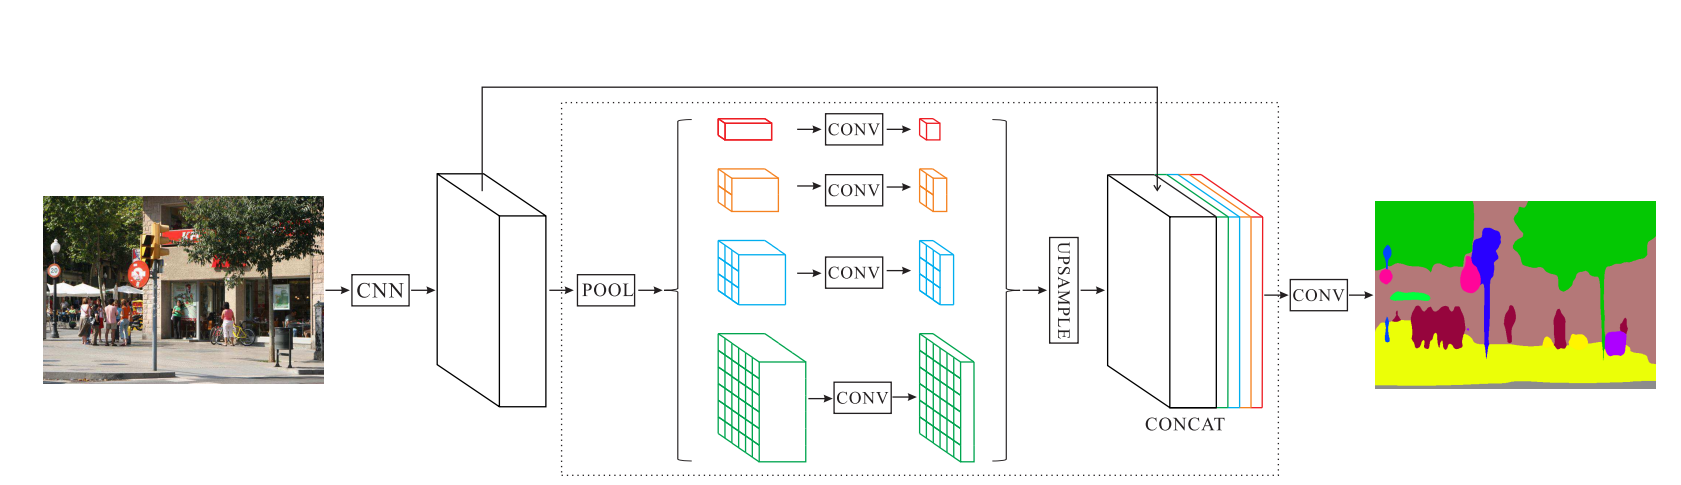

In [ ]:
def pspnet(num_classes=2, input_shape=(176, 320, 3)):
  img_input = Input(input_shape)

  x = Conv2D(32, (3,3), padding='same')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(32, (3,3), padding='same')(x)

  # Pooling
  block_1_out = MaxPooling2D((2,2))(x)
  block_2_out = MaxPooling2D((4,4))(x)
  block_3_out = MaxPooling2D((8,8))(x)
  block_4_out = MaxPooling2D((16,16))(x)

  # Серточные слои
  block_1_out = Conv2D(64, (3,3), padding='same')(block_1_out)
  block_1_out = BatchNormalization()(block_1_out)
  block_1_out = Activation('relu')(block_1_out)

  block_2_out = Conv2D(64, (3,3), padding='same')(block_2_out)
  block_2_out = BatchNormalization()(block_2_out)
  block_2_out = Activation('relu')(block_2_out)

  block_3_out = Conv2D(64, (3,3), padding='same')(block_3_out)
  block_3_out = BatchNormalization()(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  block_4_out = Conv2D(64, (3,3), padding='same')(block_4_out)
  block_4_out = BatchNormalization()(block_4_out)
  block_4_out = Activation('relu')(block_4_out)

  # Conv2DTranspose
  block_1_out = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(block_1_out)
  block_1_out = BatchNormalization()(block_1_out)
  block_1_out = Activation('relu')(block_1_out)

  block_2_out = Conv2DTranspose(32, (3,3), strides=(4,4), padding='same')(block_2_out)
  block_2_out = BatchNormalization()(block_2_out)
  block_2_out = Activation('relu')(block_2_out)

  block_3_out = Conv2DTranspose(32, (3,3), strides=(8,8), padding='same')(block_3_out)
  block_3_out = BatchNormalization()(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  block_4_out = Conv2DTranspose(32, (3,3), strides=(16,16), padding='same')(block_4_out)
  block_4_out = BatchNormalization()(block_4_out)
  block_4_out = Activation('relu')(block_4_out)

  # Объединение слоев
  out = concatenate([block_1_out, block_2_out, block_3_out, block_4_out])

  # Выходной слой
  out = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(out)

  model = Model(img_input, out)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
# Создание модели
pspnet_model = pspnet()

## Просмотр модели

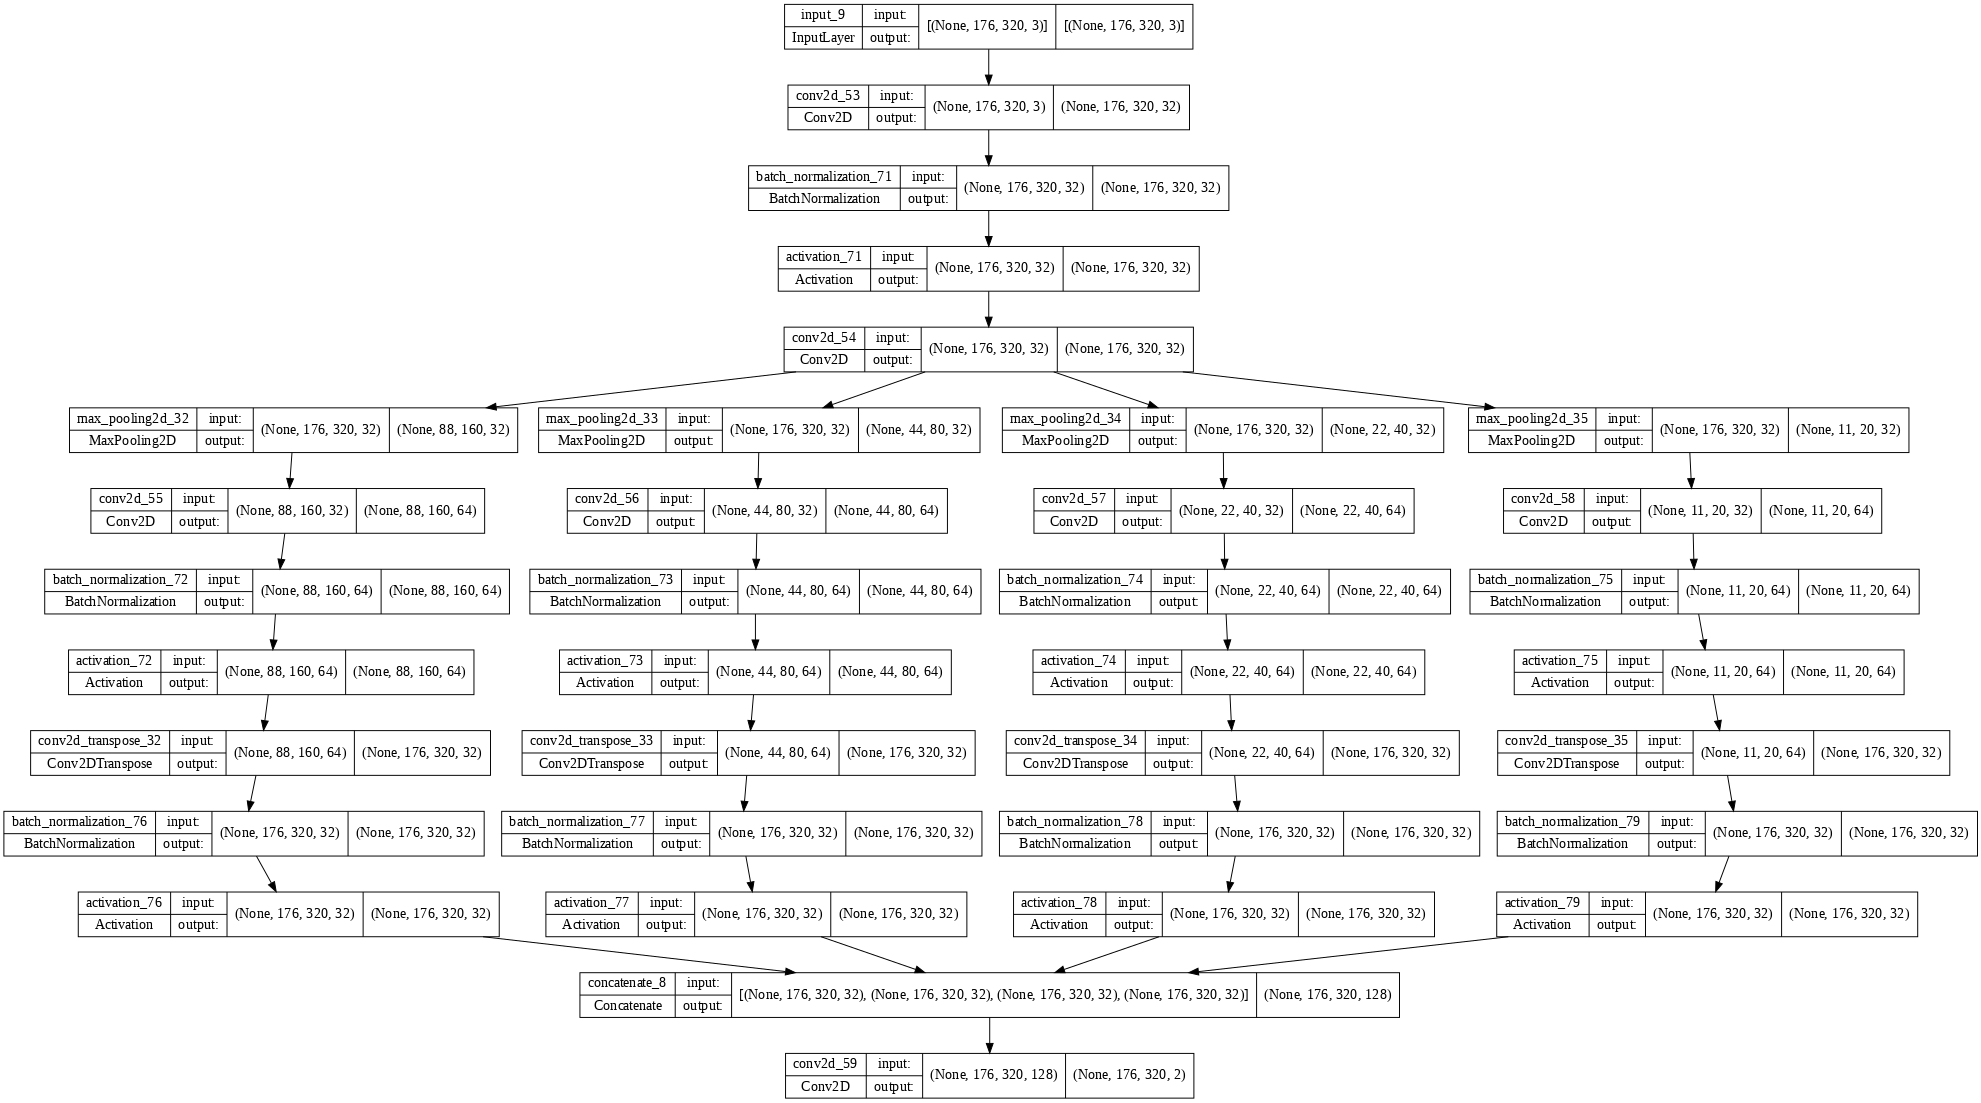

In [ ]:
plot_model(pspnet_model, show_shapes=True, dpi=70)

## Обучение

In [ ]:
history = pspnet_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data = (x_val, y_val))

Epoch 1/50
57/57 [==============================] - 35s 390ms/step - loss: 0.4248 - dice_coef: 0.7142 - val_loss: 0.5842 - val_dice_coef: 0.5690
Epoch 2/50
57/57 [==============================] - 20s 355ms/step - loss: 0.1758 - dice_coef: 0.8776 - val_loss: 0.4741 - val_dice_coef: 0.6378
Epoch 3/50
57/57 [==============================] - 20s 354ms/step - loss: 0.1400 - dice_coef: 0.9060 - val_loss: 0.3402 - val_dice_coef: 0.7358
Epoch 4/50
57/57 [==============================] - 20s 353ms/step - loss: 0.1225 - dice_coef: 0.9200 - val_loss: 0.2306 - val_dice_coef: 0.8178
Epoch 5/50
57/57 [==============================] - 20s 352ms/step - loss: 0.1113 - dice_coef: 0.9281 - val_loss: 0.1456 - val_dice_coef: 0.8900
Epoch 6/50
57/57 [==============================] - 20s 353ms/step - loss: 0.1024 - dice_coef: 0.9351 - val_loss: 0.1218 - val_dice_coef: 0.9133
Epoch 7/50
57/57 [==============================] - 20s 359ms/step - loss: 0.0959 - dice_coef: 0.9396 - val_loss: 0.1086 - val_dic

In [ ]:
# Посмотрим лучших результат
max(history.history['val_dice_coef']) * 100

96.50037884712219

In [ ]:
# Сохраним полученные веса
pspnet_model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/pspnet_model.h5')

## Распознавание



In [ ]:
# Если нужно то снова создадим модель и загрузим веса
pspnet_model = pspnet_model()
pspnet_model.load_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/pspnet_model.h5')

[28 38 45 53 74 28]


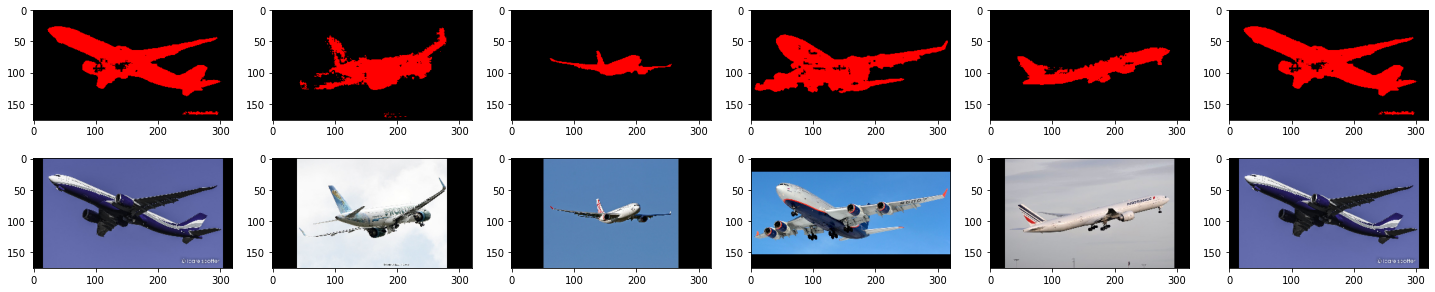

In [ ]:
count = 6
num_classes = 2 
indexes = np.random.randint(0, len(x_val), count)   # Получаем count случайных индексов
print(indexes)
fig, axs = plt.subplots(2, count, figsize=(25,5))
for i, idx in enumerate(indexes):
  predict = np.array(pspnet_model.predict(x_val[idx].reshape(1, img_width, img_height, 3)))   # (1, 176, 320, 2)
  pr = predict[0]
  pr = pr.reshape(-1, num_classes)      # (56320, 2)
  pr1 = []                                 # Пустой лист под сегментированную картинку из predicta
  
  for k in range(len(pr)):
    pr1.append(index2color(pr[k]))
  
  pr1 = np.array(pr1)
  pr1 = pr1.reshape(img_width, img_height, 3)
  img = Image.fromarray(pr1.astype('uint8'))
  axs[0,i].imshow(img.convert('RGBA'))
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8')))
  
plt.show()

**Как видно результат не очень хороший**

# Вариант **2** - Добавление **MaxPooling** и изменение гиперпараметров

In [ ]:
def pspnet_2(num_classes=2, input_shape=(176, 320, 3)):
  img_input = Input(input_shape)

  x = Conv2D(64, (3,3), padding='same')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Pooling
  block_1_out = MaxPooling2D((2,2))(x)
  block_2_out = MaxPooling2D((4,4))(x)
  block_3_out = MaxPooling2D((8,8))(x)
  block_4_out = MaxPooling2D((16,16))(x)

  block_5_out = MaxPooling2D((2,2))(x)
  block_6_out = MaxPooling2D((4,4))(x)
  block_7_out = MaxPooling2D((8,8))(x)
  block_8_out = MaxPooling2D((16,16))(x)

  # Серточные слои
  block_1_out = Conv2D(128, (3,3), padding='same')(block_1_out)
  block_1_out = BatchNormalization()(block_1_out)
  block_1_out = Activation('relu')(block_1_out)

  block_2_out = Conv2D(128, (3,3), padding='same')(block_2_out)
  block_2_out = BatchNormalization()(block_2_out)
  block_2_out = Activation('relu')(block_2_out)

  block_3_out = Conv2D(128, (3,3), padding='same')(block_3_out)
  block_3_out = BatchNormalization()(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  block_4_out = Conv2D(128, (3,3), padding='same')(block_4_out)
  block_4_out = BatchNormalization()(block_4_out)
  block_4_out = Activation('relu')(block_4_out)

  block_5_out = Conv2D(128, (3,3), padding='same')(block_5_out)
  block_5_out = BatchNormalization()(block_5_out)
  block_5_out = Activation('relu')(block_5_out)

  block_6_out = Conv2D(128, (3,3), padding='same')(block_6_out)
  block_6_out = BatchNormalization()(block_6_out)
  block_6_out = Activation('relu')(block_6_out)

  block_7_out = Conv2D(128, (3,3), padding='same')(block_7_out)
  block_7_out = BatchNormalization()(block_7_out)
  block_7_out = Activation('relu')(block_7_out)

  block_8_out = Conv2D(128, (3,3), padding='same')(block_8_out)
  block_8_out = BatchNormalization()(block_8_out)
  block_8_out = Activation('relu')(block_8_out)



  # Conv2DTranspose
  block_1_out = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(block_1_out)
  block_1_out = BatchNormalization()(block_1_out)
  block_1_out = Activation('relu')(block_1_out)

  block_2_out = Conv2DTranspose(64, (3,3), strides=(4,4), padding='same')(block_2_out)
  block_2_out = BatchNormalization()(block_2_out)
  block_2_out = Activation('relu')(block_2_out)

  block_3_out = Conv2DTranspose(64, (3,3), strides=(8,8), padding='same')(block_3_out)
  block_3_out = BatchNormalization()(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  block_4_out = Conv2DTranspose(64, (3,3), strides=(16,16), padding='same')(block_4_out)
  block_4_out = BatchNormalization()(block_4_out)
  block_4_out = Activation('relu')(block_4_out)

  block_5_out = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(block_5_out)
  block_5_out = BatchNormalization()(block_5_out)
  block_5_out = Activation('relu')(block_5_out)

  block_6_out = Conv2DTranspose(64, (3,3), strides=(4,4), padding='same')(block_6_out)
  block_6_out = BatchNormalization()(block_6_out)
  block_6_out = Activation('relu')(block_6_out)

  block_7_out = Conv2DTranspose(64, (3,3), strides=(8,8), padding='same')(block_7_out)
  block_7_out = BatchNormalization()(block_7_out)
  block_7_out = Activation('relu')(block_7_out)

  block_8_out = Conv2DTranspose(64, (3,3), strides=(16,16), padding='same')(block_8_out)
  block_8_out = BatchNormalization()(block_8_out)
  block_8_out = Activation('relu')(block_8_out)

  # Объединение слоев
  out = concatenate([block_1_out, block_2_out, block_3_out, block_4_out, block_5_out, block_6_out, block_7_out, block_8_out])

  # Выходной слой
  out = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(out)

  model = Model(img_input, out)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
# Создание модели
pspnet_model_2 = pspnet_2()

## Просмотр модели

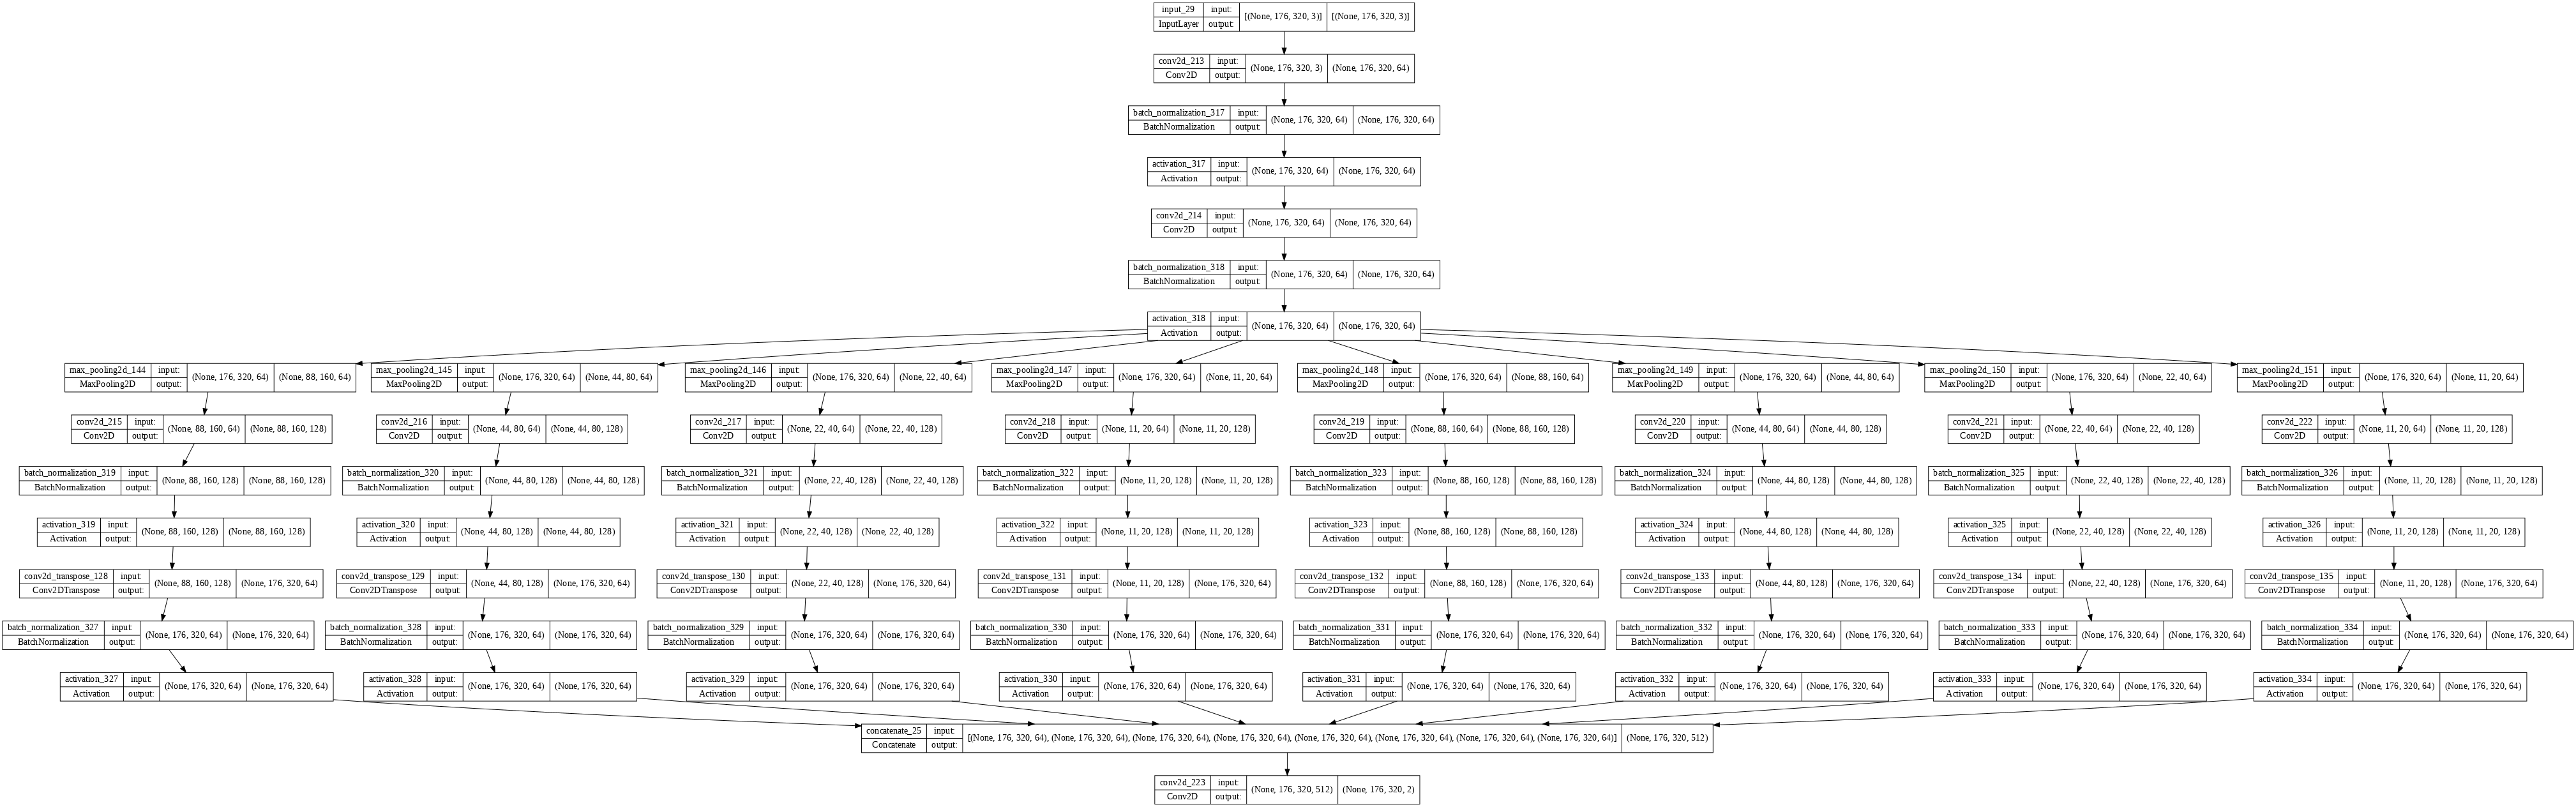

In [ ]:
plot_model(pspnet_model_2, show_shapes=True, dpi=70)

## Обучение

In [ ]:
history_2 = pspnet_model_2.fit(x_train, y_train, epochs=50, batch_size=16, validation_data = (x_val, y_val))

Epoch 1/50
57/57 [==============================] - 65s 845ms/step - loss: 0.1954 - dice_coef: 0.8781 - val_loss: 0.5261 - val_dice_coef: 0.5977
Epoch 2/50
57/57 [==============================] - 46s 810ms/step - loss: 0.1078 - dice_coef: 0.9349 - val_loss: 0.2985 - val_dice_coef: 0.7576
Epoch 3/50
57/57 [==============================] - 47s 820ms/step - loss: 0.0911 - dice_coef: 0.9459 - val_loss: 0.1619 - val_dice_coef: 0.8696
Epoch 4/50
57/57 [==============================] - 47s 825ms/step - loss: 0.0837 - dice_coef: 0.9524 - val_loss: 0.1290 - val_dice_coef: 0.9066
Epoch 5/50
57/57 [==============================] - 47s 830ms/step - loss: 0.0792 - dice_coef: 0.9548 - val_loss: 0.0847 - val_dice_coef: 0.9413
Epoch 6/50
57/57 [==============================] - 47s 833ms/step - loss: 0.0739 - dice_coef: 0.9580 - val_loss: 0.0785 - val_dice_coef: 0.9493
Epoch 7/50
57/57 [==============================] - 48s 835ms/step - loss: 0.0714 - dice_coef: 0.9602 - val_loss: 0.0672 - val_dic

In [ ]:
# Посмотрим лучших результат
max(history_2.history['val_dice_coef']) * 100

97.98210859298706

In [ ]:
# Сохраним полученные веса
pspnet_model_2.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/pspnet_model_2.h5')

## Распознавание



In [ ]:
# Если нужно то снова создадим модель и загрузим веса
pspnet_model_2 = pspnet_model()
pspnet_model_2.load_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/pspnet_model_2.h5')

[87 56 22 29 87 16]


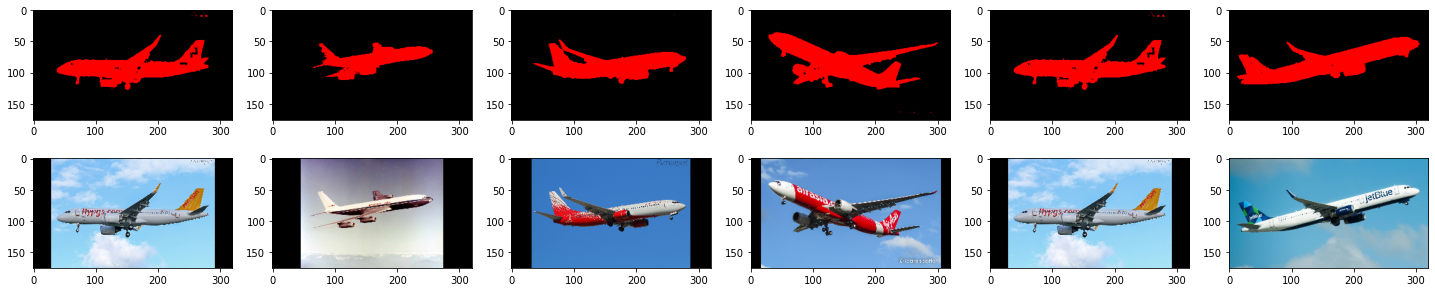

In [ ]:
count = 6
num_classes = 2 
indexes = np.random.randint(0, len(x_val), count)   # Получаем count случайных индексов
print(indexes)
fig, axs = plt.subplots(2, count, figsize=(25,5))
for i, idx in enumerate(indexes):
  predict = np.array(pspnet_model_2.predict(x_val[idx].reshape(1, img_width, img_height, 3)))   # (1, 176, 320, 2)
  pr = predict[0]
  pr = pr.reshape(-1, num_classes)      # (56320, 2)
  pr1 = []                                 # Пустой лист под сегментированную картинку из predicta
  
  for k in range(len(pr)):
    pr1.append(index2color(pr[k]))
  
  pr1 = np.array(pr1)
  pr1 = pr1.reshape(img_width, img_height, 3)
  img = Image.fromarray(pr1.astype('uint8'))
  axs[0,i].imshow(img.convert('RGBA'))
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8')))
  
plt.show()

Уже стало намного лучше. Но можно еще дообучить сеть, уменьшив шаг обучения.

In [ ]:
pspnet_model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

In [ ]:
history_2 = pspnet_model_2.fit(x_train, y_train, epochs=20, batch_size=16, validation_data = (x_val, y_val))

Epoch 1/20
57/57 [==============================] - 48s 814ms/step - loss: 0.0458 - dice_coef: 0.9758 - val_loss: 0.0400 - val_dice_coef: 0.9805
Epoch 2/20
57/57 [==============================] - 47s 816ms/step - loss: 0.0469 - dice_coef: 0.9756 - val_loss: 0.0403 - val_dice_coef: 0.9793
Epoch 3/20
57/57 [==============================] - 47s 823ms/step - loss: 0.0450 - dice_coef: 0.9753 - val_loss: 0.0393 - val_dice_coef: 0.9789
Epoch 4/20
57/57 [==============================] - 47s 830ms/step - loss: 0.0451 - dice_coef: 0.9768 - val_loss: 0.0409 - val_dice_coef: 0.9777
Epoch 5/20
57/57 [==============================] - 48s 834ms/step - loss: 0.0437 - dice_coef: 0.9768 - val_loss: 0.0389 - val_dice_coef: 0.9796
Epoch 6/20
57/57 [==============================] - 48s 835ms/step - loss: 0.0434 - dice_coef: 0.9771 - val_loss: 0.0383 - val_dice_coef: 0.9809
Epoch 7/20
57/57 [==============================] - 48s 837ms/step - loss: 0.0436 - dice_coef: 0.9765 - val_loss: 0.0410 - val_dic

In [ ]:
# Посмотрим лучших результат
max(history_2.history['val_dice_coef']) * 100

98.18283319473267

In [ ]:
# Сохраним полученные веса
pspnet_model_2.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/pspnet_model_2.h5')

[37 23  2 36 14 94]


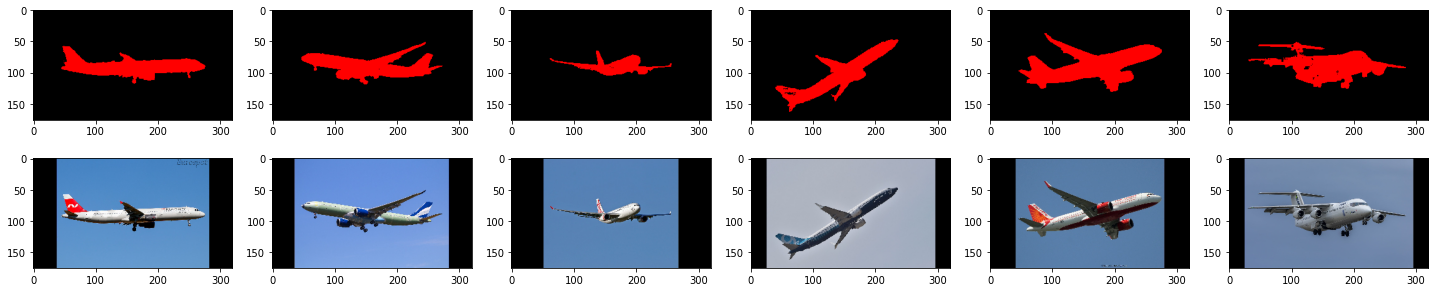

In [ ]:
count = 6
num_classes = 2 
indexes = np.random.randint(0, len(x_val), count)   # Получаем count случайных индексов
print(indexes)
fig, axs = plt.subplots(2, count, figsize=(25,5))
for i, idx in enumerate(indexes):
  predict = np.array(pspnet_model_2.predict(x_val[idx].reshape(1, img_width, img_height, 3)))   # (1, 176, 320, 2)
  pr = predict[0]
  pr = pr.reshape(-1, num_classes)      # (56320, 2)
  pr1 = []                                 # Пустой лист под сегментированную картинку из predicta
  
  for k in range(len(pr)):
    pr1.append(index2color(pr[k]))
  
  pr1 = np.array(pr1)
  pr1 = pr1.reshape(img_width, img_height, 3)
  img = Image.fromarray(pr1.astype('uint8'))
  axs[0,i].imshow(img.convert('RGBA'))
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8')))
  
plt.show()

# Выводы:

1. В данной домашней работе воспроизводилась архитектура **PSPnet**
2. С помощью данной нейронной сети удалось добиться **98.18%**
3. Увеличение количества слоев **MaxPooling2D**, с последующим развертованием и изменения гиперпараметров, слоя **Conv2D**, помогло добиться лучшего результата.
4. Данная работа помогает лучше понять:
   - Как разные архитектуры сети влияют на конечный результат.
   - Функциональное программирование.
   - Работу с размерностями слоев.
5. Для лучшего результата можно применять разные архитектуры и увеличение обучающей выборки. 